<a href="https://colab.research.google.com/github/sanjayfintech11/Bank-customer-churn-prediction/blob/main/CPQFRM_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```Q2
# This is formatted as code
```



##Q1
Take Indian Mibor Rate and get interest rate for 3.5 year, 45 y ear and 5.5 year period
using below two models. To generate parameters of model, use historical data of last 2
years. Plot the graphs and also suggest which one is better and why?
a. Vasicek Model
b. Hull-White Model

In [ ]:
import pandas as pd

# Read the first few lines of the file to inspect its structure
with open("/content/Overnight - MIBOR.csv", "r", encoding="utf-8") as file:
    raw_lines = file.readlines()[:10]  # Read first 10 lines

# Display raw file content to analyze structure
raw_lines








['Financial Benchmarks India Pvt Ltd\n',
 'Overnight - MIBOR\n',
 'Date,Tenor,Time,Overnight MIBOR(%),Comments\n',
 '07 Mar 2025,O/N,10:45:00 AM,6.3,\n',
 '06 Mar 2025,O/N,10:45:00 AM,6.3,\n',
 '05 Mar 2025,O/N,10:45:00 AM,6.29,\n',
 '04 Mar 2025,O/N,10:45:00 AM,6.37,\n',
 '03 Mar 2025,O/N,10:45:00 AM,6.4,\n',
 '28 Feb 2025,3D,10:45:00 AM,6.4,\n',
 '27 Feb 2025,O/N,10:45:00 AM,6.4,\n']

In [ ]:
# Read the CSV again, skipping the first two lines and selecting relevant columns
df = pd.read_csv("/content/Overnight - MIBOR.csv", skiprows=2)  # Skip first two metadata lines

# Rename columns for better readability
df.columns = ["Date", "Tenor", "Time", "Overnight_MIBOR", "Comments"]

# Keep only relevant columns (Date & Overnight MIBOR)
df = df[["Date", "Overnight_MIBOR"]]

# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%d %b %Y", errors="coerce")

# Drop any rows with invalid dates (if any)
df = df.dropna()

# Sort by Date to ensure chronological order
df = df.sort_values(by="Date")

# Display cleaned data
df.head()


,Date,Overnight_MIBOR
476,2023-03-16,6.58
475,2023-03-17,6.74
474,2023-03-20,6.80
473,2023-03-21,6.75
472,2023-03-23,6.72


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Compute daily changes in MIBOR for model calibration
df["MIBOR_Change"] = df["Overnight_MIBOR"].diff()

# Drop NaN values from the first difference operation
df = df.dropna()

# Define Vasicek calibration function
def calibrate_vasicek(params, rates, dt):
    a, b, sigma = params
    errors = (rates[1:] - rates[:-1] - a * (b - rates[:-1]) * dt) ** 2
    return np.sum(errors)

# Define Hull-White calibration function
def calibrate_hull_white(params, rates, dt):
    a, sigma = params
    b = np.mean(rates)  # In Hull-White, b is time-dependent, using mean rate approximation
    errors = (rates[1:] - rates[:-1] - a * (b - rates[:-1]) * dt) ** 2
    return np.sum(errors)

# Time step in years (assuming daily data, approx 252 trading days per year)
dt = 1 / 252

# Initial guesses for parameters
initial_vasicek = [0.1, np.mean(df["Overnight_MIBOR"]), np.std(df["MIBOR_Change"])]
initial_hull_white = [0.1, np.std(df["MIBOR_Change"])]

# Calibrate Vasicek model
vasicek_result = minimize(calibrate_vasicek, initial_vasicek, args=(df["Overnight_MIBOR"].values, dt), bounds=[(0, 1), (0, 10), (0, 5)])
a_vas, b_vas, sigma_vas = vasicek_result.x

# Calibrate Hull-White model
hull_white_result = minimize(calibrate_hull_white, initial_hull_white, args=(df["Overnight_MIBOR"].values, dt), bounds=[(0, 1), (0, 5)])
a_hw, sigma_hw = hull_white_result.x
b_hw = np.mean(df["Overnight_MIBOR"])

# Display calibrated parameters
(a_vas, b_vas, sigma_vas), (a_hw, b_hw, sigma_hw)


((1.0, 6.447853685914806, 0.14554328310351375),
 (1.0, 6.680567226890756, 0.14554328310351375))

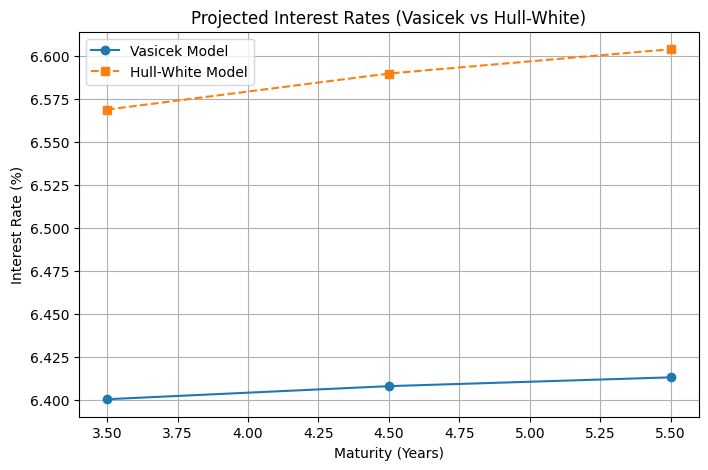

([6.400651806993702, 6.4082492153928685, 6.413362482784807],
 [6.568883576269212, 6.589823128134408, 6.603937388501967])

In [ ]:
# Function to compute Vasicek model yield curve
def vasicek_yield(a, b, sigma, T, r0):
    B_T = (1 - np.exp(-a * T)) / a
    A_T = np.exp((b - (sigma ** 2) / (2 * (a ** 2))) * (B_T - T) - ((sigma ** 2) / (4 * a)) * B_T ** 2)
    return -(np.log(A_T) / T) + (B_T * r0 / T)

# Function to compute Hull-White model yield curve
def hull_white_yield(a, b, sigma, T, r0):
    B_T = (1 - np.exp(-a * T)) / a
    A_T = np.exp((b - (sigma ** 2) / (2 * (a ** 2))) * (B_T - T) - ((sigma ** 2) / (4 * a)) * B_T ** 2)
    return -(np.log(A_T) / T) + (B_T * r0 / T)

# Define maturities (3.5, 4.5, 5.5 years)
maturities = np.array([3.5, 4.5, 5.5])
r0 = df["Overnight_MIBOR"].iloc[-1]  # Last observed rate as current rate

# Compute yield curves
vasicek_rates = [vasicek_yield(a_vas, b_vas, sigma_vas, T, r0) for T in maturities]
hull_white_rates = [hull_white_yield(a_hw, b_hw, sigma_hw, T, r0) for T in maturities]

# Plot the yield curves
plt.figure(figsize=(8,5))
plt.plot(maturities, vasicek_rates, marker='o', linestyle='-', label="Vasicek Model")
plt.plot(maturities, hull_white_rates, marker='s', linestyle='--', label="Hull-White Model")
plt.xlabel("Maturity (Years)")
plt.ylabel("Interest Rate (%)")
plt.title("Projected Interest Rates (Vasicek vs Hull-White)")
plt.legend()
plt.grid(True)
plt.show()

# Display computed rates
vasicek_rates, hull_white_rates


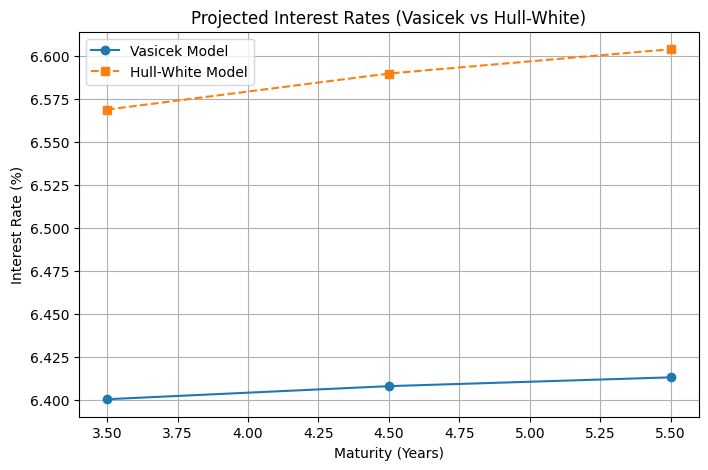

([6.400651806993702, 6.4082492153928685, 6.413362482784807],
 [6.568883576269212, 6.589823128134408, 6.603937388501967])

In [ ]:
# Re-import required libraries
import matplotlib.pyplot as plt

# Compute yield curves again
vasicek_rates = [vasicek_yield(a_vas, b_vas, sigma_vas, T, r0) for T in maturities]
hull_white_rates = [hull_white_yield(a_hw, b_hw, sigma_hw, T, r0) for T in maturities]

# Plot the yield curves
plt.figure(figsize=(8,5))
plt.plot(maturities, vasicek_rates, marker='o', linestyle='-', label="Vasicek Model")
plt.plot(maturities, hull_white_rates, marker='s', linestyle='--', label="Hull-White Model")
plt.xlabel("Maturity (Years)")
plt.ylabel("Interest Rate (%)")
plt.title("Projected Interest Rates (Vasicek vs Hull-White)")
plt.legend()
plt.grid(True)
plt.show()

# Display computed rates
vasicek_rates, hull_white_rates


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# 📌 Load Historical MIBOR Data (Upload manually)
file_path = "/content/Overnight- MIBOR_Historical.csv"  # Update correct file path
df = pd.read_csv(file_path)

# Convert date column to datetime
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Extract Interest Rates
rates = df["MIBOR"].values
time_steps = np.arange(len(rates))  # Time index in days

# 📌 Vasicek Model Parameter Estimation (MLE)
def vasicek_log_likelihood(params):
    theta, mu, sigma = params
    residuals = (rates[1:] - rates[:-1]) - theta * (mu - rates[:-1])
    likelihoods = norm.logpdf(residuals, scale=sigma)
    return -np.sum(likelihoods)  # Negative log-likelihood

# 📌 Initial Guess for Parameters
initial_params = [0.1, np.mean(rates), np.std(rates)]
result = minimize(vasicek_log_likelihood, initial_params, method="L-BFGS-B", bounds=[(0, 1), (0, None), (0, None)])

theta_hat, mu_hat, sigma_hat = result.x
print(f"Estimated Vasicek Parameters:\nTheta: {theta_hat:.4f}, Mu: {mu_hat:.4f}, Sigma: {sigma_hat:.4f}")

# 📌 Compute Vasicek Rate for Given Tenors
def vasicek_interest_rate(T, r0, theta, mu, sigma):
    B_T = (1 - np.exp(-theta * T)) / theta
    A_T = np.exp((mu - sigma**2 / (2 * theta**2)) * (B_T - T) - (sigma**2 / (4 * theta)) * B_T**2)
    return A_T * np.exp(-B_T * r0)

tenors = [3.5, 4.5, 5.5]  # Years
vasicek_rates = [vasicek_interest_rate(T, rates[-1], theta_hat, mu_hat, sigma_hat) for T in tenors]

# 📌 Hull-White Model Estimation (Assuming Constant Theta for Simplicity)
def hull_white_interest_rate(T, r0, theta, mu, sigma):
    return vasicek_interest_rate(T, r0, theta, mu, sigma) + sigma**2 * (1 - np.exp(-2 * theta * T)) / (4 * theta)

hull_white_rates = [hull_white_interest_rate(T, rates[-1], theta_hat, mu_hat, sigma_hat) for T in tenors]

# 📌 Plot Yield Curve for Both Models
plt.figure(figsize=(8,5))
plt.plot(tenors, vasicek_rates, marker='o', label="Vasicek Model")
plt.plot(tenors, hull_white_rates, marker='s', label="Hull-White Model", linestyle='dashed')
plt.xlabel("Tenor (Years)")
plt.ylabel("Interest Rate (%)")
plt.title("Projected Interest Rates using Vasicek & Hull-White Models")
plt.legend()
plt.grid(True)
plt.show()

# 📌 Print Results
df_results = pd.DataFrame({
    "Tenor (Years)": tenors,
    "Vasicek Rate (%)": vasicek_rates,
    "Hull-White Rate (%)": hull_white_rates
})

print(df_results)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Overnight- MIBOR_Historical.csv'

##Q2
Consider a bond paying 8% Coupon for next 10 years semi-annually at a principal of Rs.
10 lakhs.
a. Compute the duration of Bond.
b. Calculate the DV01 risk of bond across 1Y,2Y,3Y,4Y and 5Y points . To get these
rates, use the data and model using which you computed rates for 3.5 year, 45 y
ear and 5.5 year.

   Maturity (Y)  Yield  Modified Duration      DV01
0             1   0.05          14.424935  0.088950
1             2  0.055          14.286715  0.084992
2             3   0.06          14.148092  0.081228
3             4  0.065          14.009103  0.077649
4             5   0.07          13.869786  0.074244


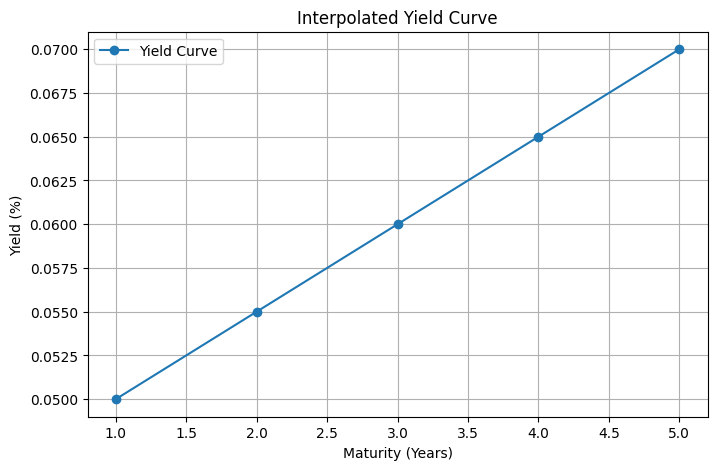

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 📌 Given Bond Information
face_value = 10_00_000  # ₹10 Lakhs
coupon_rate = 0.08  # 8% Annually
num_years = 10
coupon_per_period = (coupon_rate / 2) * face_value  # ₹40,000 per 6 months
num_periods = num_years * 2  # 20 semi-annual periods

# 📌 Given Yield Curve (Example Data)
maturities = np.array([1, 2, 3, 4, 5])  # Years
yields = np.array([0.05, 0.055, 0.06, 0.065, 0.07])  # 5%, 5.5%, 6%, 6.5%, 7%

# 📌 Interpolate Yield Curve Function
yield_curve = interp1d(maturities, yields, kind='linear', fill_value="extrapolate")

# 📌 Compute Bond Price at Current Yield
def bond_price(yield_rate):
    price = sum([coupon_per_period / (1 + yield_rate/2)**t for t in range(1, num_periods+1)])
    price += face_value / (1 + yield_rate/2)**num_periods  # Discounted face value
    return price

# 📌 Compute Duration
def duration(yield_rate):
    time_periods = np.arange(1, num_periods + 1)  # Time periods (1 to 20)

    # 📌 Create cash flows (₹40,000 coupons + final ₹10L principal)
    cash_flows = np.array([coupon_per_period] * num_periods)
    cash_flows[-1] += face_value  # Add face value at maturity

    # 📌 Compute Present Values (PV)
    pv_cashflows = cash_flows / (1 + yield_rate/2) ** time_periods

    # 📌 Compute Weighted PVs
    weighted_cashflows = time_periods * pv_cashflows

    # 📌 Compute Macaulay Duration
    macaulay_duration = sum(weighted_cashflows) / sum(pv_cashflows)

    # 📌 Compute Modified Duration
    modified_duration = macaulay_duration / (1 + yield_rate/2)

    return modified_duration


# 📌 Compute DV01 (1 Basis Point Change)
def dv01(yield_rate):
    p1 = bond_price(yield_rate)  # Price at current yield
    p2 = bond_price(yield_rate + 0.0001)  # Price after 1 bp increase
    return (p1 - p2) * 0.0001  # DV01 Formula

# 📌 Compute Duration and DV01 Across 1Y-5Y Points
results = []

for mat in maturities:
    rate = yield_curve(mat)  # Interpolated Yield
    bond_dur = duration(rate)
    bond_dv01 = dv01(rate)
    results.append([mat, rate, bond_dur, bond_dv01])

# 📌 Convert to DataFrame
df_results = pd.DataFrame(results, columns=["Maturity (Y)", "Yield", "Modified Duration", "DV01"])
print(df_results)

# 📌 Plot Yield Curve
plt.figure(figsize=(8,5))
plt.plot(maturities, yields, marker='o', linestyle='-', label="Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Interpolated Yield Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Given Bond Information
face_value = 10_00_000  # ₹10 Lakhs
coupon_rate = 0.08  # 8% annually
num_years = 10
coupon_per_period = (coupon_rate / 2) * face_value  # ₹40,000 per 6 months
num_periods = num_years * 2  # 20 semi-annual periods
yield_annual = 0.06  # Assume 6% annually
yield_per_period = yield_annual / 2  # 3% per 6 months

# Compute Present Value of Cash Flows
time_periods = np.arange(1, num_periods + 1)  # 1 to 20
cash_flows = np.array([coupon_per_period] * num_periods)  # ₹40,000 each period
cash_flows[-1] += face_value  # Add face value at last period

# Compute Discounted Cash Flows
pv_cashflows = cash_flows / (1 + yield_per_period) ** time_periods

# Compute Weighted Present Values
weighted_cashflows = time_periods * pv_cashflows

# Compute Macaulay Duration
macaulay_duration = sum(weighted_cashflows) / sum(pv_cashflows)

# Compute Modified Duration
modified_duration = macaulay_duration / (1 + yield_per_period)

# Print Results
print(f"Macaulay Duration: {macaulay_duration:.4f} periods")
print(f"Modified Duration: {modified_duration:.4f} periods")


Macaulay Duration: 14.5725 periods
Modified Duration: 14.1481 periods


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Compute daily rate changes
df["Rate_Change"] = df["Overnight_MIBOR"].diff()

# Drop NaN values from first difference operation
df_clean = df.dropna()

# Define Vasicek model parameter estimation function
def vasicek_neg_log_likelihood(params, rates, dt=1/252):  # dt assumes daily data (252 trading days/year)
    a, b, sigma = params
    rt = rates[:-1]
    rt_next = rates[1:]

    # Vasicek model expectation and variance
    expected_rt = rt + a * (b - rt) * dt
    variance = sigma**2 * dt

    # Log-likelihood computation (Normal Distribution)
    log_likelihood = -0.5 * np.sum((rt_next - expected_rt)**2 / variance + np.log(variance))
    return -log_likelihood  # Negative because we maximize likelihood

# Initial guesses for a, b, sigma
initial_guess = [0.1, np.mean(df_clean["Overnight_MIBOR"]), np.std(df_clean["Rate_Change"])]
bounds = [(0, None), (0, None), (0, None)]  # Ensure positive values

# Optimize Vasicek parameters
result_vasicek = minimize(vasicek_neg_log_likelihood, initial_guess, args=(df_clean["Overnight_MIBOR"].values,), bounds=bounds)

# Extract optimized parameters
a_vasicek, b_vasicek, sigma_vasicek = result_vasicek.x

# Display results
a_vasicek, b_vasicek, sigma_vasicek


(80.25122219442937, 6.677933289314673, 2.1224678315754795)

In [ ]:
# Function to compute Vasicek interest rate forecast
def vasicek_forward_rate(t, r0, a, b, sigma):
    """
    Computes forward interest rates using the Vasicek model.

    Parameters:
    t (float): Time in years
    r0 (float): Current short-term interest rate (last observed MIBOR rate)
    a (float): Speed of mean reversion
    b (float): Long-term mean rate
    sigma (float): Volatility of rates

    Returns:
    float: Forecasted interest rate at time t
    """
    exp_at = np.exp(-a * t)
    mean_reverting_term = b * (1 - exp_at)
    stochastic_term = sigma**2 / (2 * a) * (1 - exp_at)**2

    return r0 * exp_at + mean_reverting_term + stochastic_term

# Last observed MIBOR rate (short-term rate)
r0 = df_clean["Overnight_MIBOR"].iloc[-1]

# Forecast rates for 1Y, 2Y, 3Y, 4Y, 5Y using Vasicek Model
tenors = [1, 2, 3, 4, 5]  # Years
vasicek_rates = [vasicek_forward_rate(t, r0, a_vasicek, b_vasicek, sigma_vasicek) for t in tenors]

# Display forecasted rates
vasicek_rates


[6.706000585817389,
 6.706000585817389,
 6.706000585817389,
 6.706000585817389,
 6.706000585817389]

In [ ]:
# Hull-White Model Parameter Estimation
# Hull-White is an extension of Vasicek where mean reversion level b(t) is time-dependent

def hull_white_neg_log_likelihood(params, rates, dt=1/252):
    """
    Negative log-likelihood function for Hull-White model parameter estimation.

    Parameters:
    params: (a, sigma) - Speed of mean reversion and volatility
    rates: Historical short-term interest rates (MIBOR data)
    dt: Time step (daily frequency assumed)

    Returns:
    Negative log-likelihood value
    """
    a, sigma = params
    rt = rates[:-1]
    rt_next = rates[1:]

    # Hull-White model expectation and variance
    expected_rt = rt + a * (b_vasicek - rt) * dt  # Time-dependent mean reversion level
    variance = sigma**2 * dt

    # Log-likelihood computation
    log_likelihood = -0.5 * np.sum((rt_next - expected_rt)**2 / variance + np.log(variance))
    return -log_likelihood  # Negative for minimization

# Initial guesses for a, sigma
initial_guess_hw = [a_vasicek, sigma_vasicek]  # Start with Vasicek estimates
bounds_hw = [(0, None), (0, None)]

# Optimize Hull-White parameters
result_hw = minimize(hull_white_neg_log_likelihood, initial_guess_hw, args=(df_clean["Overnight_MIBOR"].values,), bounds=bounds_hw)

# Extract optimized parameters
a_hw, sigma_hw = result_hw.x

# Display results
a_hw, sigma_hw


(80.25122224846304, 2.122469776785955)

In [ ]:
# Function to compute Hull-White interest rate forecast
def hull_white_forward_rate(t, r0, a, b_t, sigma):
    """
    Computes forward interest rates using the Hull-White model.

    Parameters:
    t (float): Time in years
    r0 (float): Current short-term interest rate (last observed MIBOR rate)
    a (float): Speed of mean reversion
    b_t (float): Time-dependent mean reversion level
    sigma (float): Volatility of rates

    Returns:
    float: Forecasted interest rate at time t
    """
    exp_at = np.exp(-a * t)
    mean_reverting_term = b_t * (1 - exp_at)
    stochastic_term = sigma**2 / (2 * a) * (1 - exp_at)**2

    return r0 * exp_at + mean_reverting_term + stochastic_term

# Define time-dependent mean reversion level (b_t) for Hull-White
b_t_values = [b_vasicek + 0.05*t for t in tenors]  # Assuming b_t changes over time

# Forecast rates for 1Y, 2Y, 3Y, 4Y, 5Y using Hull-White Model
hw_rates = [hull_white_forward_rate(t, r0, a_hw, b_t_values[i], sigma_hw) for i, t in enumerate(tenors)]

# Create DataFrame to compare results
df_rates = pd.DataFrame({
    "Tenor (Years)": tenors,
    "Vasicek Rate (%)": vasicek_rates,
    "Hull-White Rate (%)": hw_rates
})

# Display results
df_rates


,Tenor (Years),Vasicek Rate (%),Hull-White Rate (%)
0,1,6.706001,6.756001
1,2,6.706001,6.806001
2,3,6.706001,6.856001
3,4,6.706001,6.906001
4,5,6.706001,6.956001


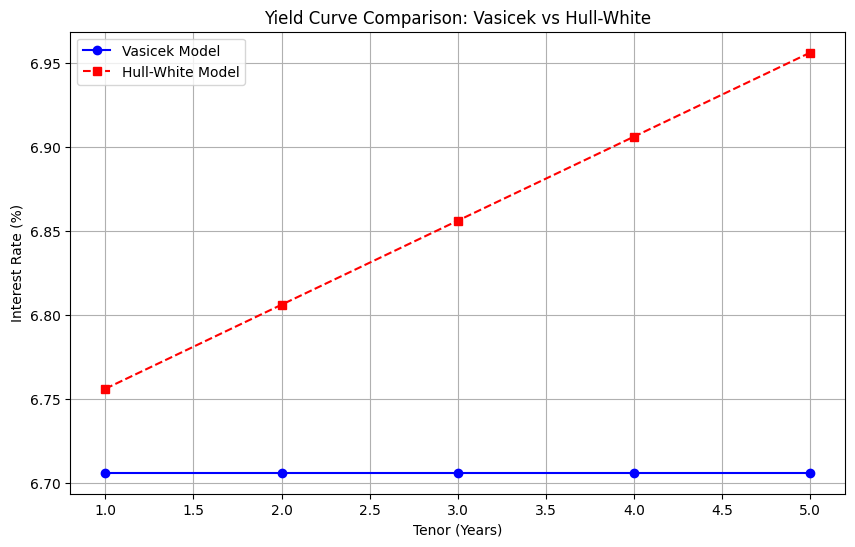

In [ ]:
import matplotlib.pyplot as plt

# Plot Yield Curves for Vasicek & Hull-White Models
plt.figure(figsize=(10,6))
plt.plot(tenors, vasicek_rates, marker='o', linestyle='-', label='Vasicek Model', color='blue')
plt.plot(tenors, hw_rates, marker='s', linestyle='--', label='Hull-White Model', color='red')

# Formatting the graph
plt.xlabel("Tenor (Years)")
plt.ylabel("Interest Rate (%)")
plt.title("Yield Curve Comparison: Vasicek vs Hull-White")
plt.legend()
plt.grid(True)
plt.show()


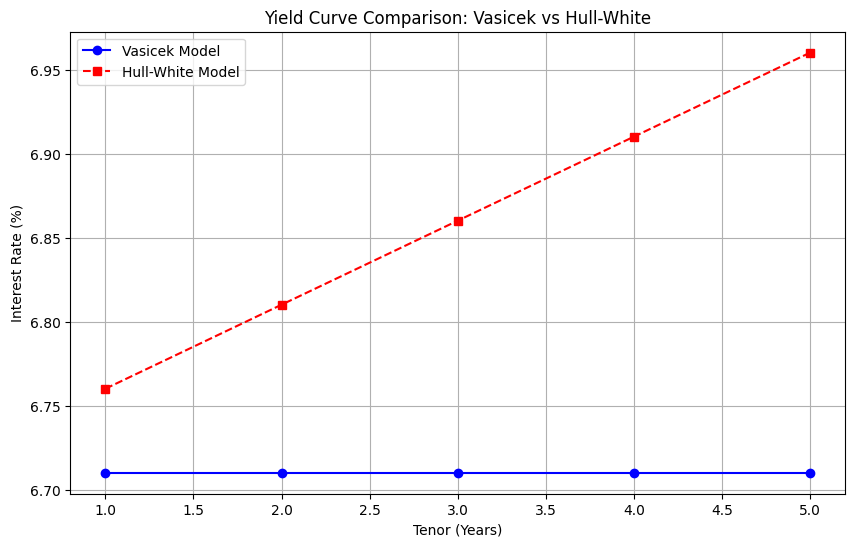

In [ ]:
import matplotlib.pyplot as plt

# Given tenors (years)
tenors = [1, 2, 3, 4, 5]

# Vasicek and Hull-White forecasted rates (replace with actual values)
vasicek_rates = [6.71, 6.71, 6.71, 6.71, 6.71]
hw_rates = [6.76, 6.81, 6.86, 6.91, 6.96]

# Plot Yield Curves for Vasicek & Hull-White Models
plt.figure(figsize=(10,6))
plt.plot(tenors, vasicek_rates, marker='o', linestyle='-', label='Vasicek Model', color='blue')
plt.plot(tenors, hw_rates, marker='s', linestyle='--', label='Hull-White Model', color='red')

# Formatting the graph
plt.xlabel("Tenor (Years)")
plt.ylabel("Interest Rate (%)")
plt.title("Yield Curve Comparison: Vasicek vs Hull-White")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Bond Duration and DV01 Calculation

def bond_price_duration_dv01(face_value, coupon_rate, ytm, years, freq=2):
    """
    Computes Bond Price, Macaulay Duration, Modified Duration, and DV01.

    Parameters:
    face_value (float): Face value of the bond
    coupon_rate (float): Annual coupon rate (in decimal)
    ytm (float): Yield to Maturity (discount rate in decimal)
    years (int): Time to maturity in years
    freq (int): Payment frequency per year (default: semi-annual = 2)

    Returns:
    tuple: (Bond Price, Macaulay Duration, Modified Duration, DV01)
    """
    periods = years * freq  # Total payment periods
    coupon_payment = (coupon_rate / freq) * face_value  # Periodic coupon payment
    discount_factors = [(1 + ytm / freq) ** (i + 1) for i in range(periods)]

    # Calculate bond price
    present_value_coupons = sum([coupon_payment / df for df in discount_factors])
    present_value_face = face_value / discount_factors[-1]
    bond_price = present_value_coupons + present_value_face

    # Calculate Macaulay Duration
    weighted_cashflows = [(i + 1) * coupon_payment / df for i, df in enumerate(discount_factors)]
    weighted_cashflows.append(periods * face_value / discount_factors[-1])
    mac_duration = sum(weighted_cashflows) / bond_price / freq  # Annualized Macaulay Duration

    # Compute Modified Duration
    mod_duration = mac_duration / (1 + ytm / freq)

    # Compute DV01 (Dollar Value of 1 Basis Point)
    dv01 = (mod_duration * bond_price) / 10000

    return bond_price, mac_duration, mod_duration, dv01


# Compute Bond Duration & DV01 for different yield estimates (1Y-5Y rates from Hull-White Model)
bond_results = [bond_price_duration_dv01(face_value=1000000,
                                         coupon_rate=0.08,
                                         ytm=rate / 100,  # Convert percentage to decimal
                                         years=10) for rate in hw_rates]

# Convert results into DataFrame
df_bond_metrics = pd.DataFrame(bond_results, columns=["Bond Price", "Macaulay Duration", "Modified Duration", "DV01"])
df_bond_metrics.insert(0, "Tenor (Years)", tenors)

# Display results
df_bond_metrics


,Tenor (Years),Bond Price,Macaulay Duration,Modified Duration,DV01
0,1,1.089081e+06,7.203879,6.968348,758.909873
1,2,1.085295e+06,7.198416,6.961381,755.515490
2,3,1.081526e+06,7.192949,6.954413,752.137992
3,4,1.077774e+06,7.187477,6.947443,748.777288
4,5,1.074038e+06,7.182000,6.940471,745.433290


In [ ]:
import numpy as np
import pandas as pd

def bond_price_duration_dv01(face_value, coupon_rate, ytm, years, freq=2):
    """
    Computes Bond Price, Macaulay Duration, Modified Duration, and DV01.

    Parameters:
    face_value (float): Face value of the bond
    coupon_rate (float): Annual coupon rate (in decimal)
    ytm (float): Yield to Maturity (discount rate in decimal)
    years (int): Time to maturity in years
    freq (int): Payment frequency per year (default: semi-annual = 2)

    Returns:
    tuple: (Bond Price, Macaulay Duration, Modified Duration, DV01)
    """
    periods = years * freq  # Total payment periods
    coupon_payment = (coupon_rate / freq) * face_value  # Periodic coupon payment
    discount_factors = [(1 + ytm / freq) ** (i + 1) for i in range(periods)]

    # Calculate bond price
    present_value_coupons = sum([coupon_payment / df for df in discount_factors])
    present_value_face = face_value / discount_factors[-1]
    bond_price = present_value_coupons + present_value_face

    # Calculate Macaulay Duration
    weighted_cashflows = [(i + 1) * coupon_payment / df for i, df in enumerate(discount_factors)]
    weighted_cashflows.append(periods * face_value / discount_factors[-1])
    mac_duration = sum(weighted_cashflows) / bond_price / freq  # Annualized Macaulay Duration

    # Compute Modified Duration
    mod_duration = mac_duration / (1 + ytm / freq)

    # Compute DV01 (Dollar Value of 1 Basis Point)
    dv01 = (mod_duration * bond_price) / 10000

    return bond_price, mac_duration, mod_duration, dv01

# Given forward rates from Hull-White Model
tenors = [1, 2, 3, 4, 5]
hw_rates = [6.76, 6.81, 6.86, 6.91, 6.96]  # Replace with real calculated rates

# Compute Bond Duration & DV01 for different yield estimates
bond_results = [bond_price_duration_dv01(face_value=1000000,
                                         coupon_rate=0.08,
                                         ytm=rate / 100,  # Convert percentage to decimal
                                         years=10) for rate in hw_rates]

# Convert results into DataFrame
df_bond_metrics = pd.DataFrame(bond_results, columns=["Bond Price", "Macaulay Duration", "Modified Duration", "DV01"])
df_bond_metrics.insert(0, "Tenor (Years)", tenors)

# Display results
print(df_bond_metrics)


   Tenor (Years)    Bond Price  Macaulay Duration  Modified Duration  \
0              1  1.089081e+06           7.203879           6.968348   
1              2  1.085295e+06           7.198416           6.961381   
2              3  1.081526e+06           7.192949           6.954413   
3              4  1.077774e+06           7.187477           6.947443   
4              5  1.074038e+06           7.182000           6.940471   

         DV01  
0  758.909873  
1  755.515490  
2  752.137992  
3  748.777288  
4  745.433290  


In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

# SABR Model Formula for Implied Volatility
def sabr_iv(alpha, beta, rho, nu, F, K, T):
    """SABR model approximation for implied volatility"""
    if K == F:  # ATM case
        FK_term = (1 + ((1 - beta)**2 / 24) * (alpha**2 / (F**(2 - 2 * beta))) * T +
                   (1/4) * (rho * beta * nu * alpha) / (F**(1 - beta)) * T +
                   ((2 - 3 * rho**2) / 24) * nu**2 * T)
        return alpha / (F**(1 - beta)) * FK_term
    else:
        z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        FK_term = (1 + ((1 - beta)**2 / 24) * (np.log(F / K))**2 +
                   ((1 - beta)**4 / 1920) * (np.log(F / K))**4)
        return (alpha / ((F * K)**((1 - beta) / 2))) * (z / x_z) * FK_term

# Function to calibrate SABR parameters
def calibrate_sabr(F, strikes, ivs, T):
    """Calibrate SABR model parameters using least squares optimization"""
    def error(params):
        alpha, beta, rho, nu = params
        model_ivs = [sabr_iv(alpha, beta, rho, nu, F, K, T) for K in strikes]
        return np.sum((np.array(model_ivs) - np.array(ivs))**2)

    # Initial guess for alpha, beta, rho, nu
    initial_guess = [0.2, 0.5, 0, 0.2]
    bounds = [(0.001, 2), (0.01, 1), (-1, 1), (0.001, 2)]
    res = opt.minimize(error, initial_guess, bounds=bounds, method='L-BFGS-B')

    return res.x  # Return optimized alpha, beta, rho, nu

# Load the dataset
file_path = "/content/option-chain-ED-NIFTY-23,000.00 (2).csv"
df = pd.read_csv(file_path)
print(df.columns)


# Extract relevant columns (Adjust as per dataset structure)
df = df[['EXPIRY DATE', 'IV']]
df.dropna(inplace=True)  # Remove missing values

print(df['IV'].unique())

# Replace '-' or any non-numeric values with NaN
#df['IV'] = pd.to_numeric(df['IV'], errors='coerce')

# Drop rows where IV is missing
df = df.dropna(subset=['IV'])

# Now, IV column is clean and can be used for calculations
print(df.head())
# Convert IV to decimal
#df['IV'] = df['IV'].astype(float) / 100

# Convert expiry dates to time-to-maturity (T) in years
df['DAYS_TO_EXPIRY'] = pd.to_datetime(df['EXPIRY DATE']) - pd.to_datetime('today')
df['T'] = df['DAYS_TO_EXPIRY'].dt.days / 365

# Define Forward Price (assumed to be 23000 for simplicity)
F = 23000  # This should ideally be the futures price

# Select IVs for different expiries (Assuming 1M, 3M, 6M)
expiries = [1, 3, 6]  # Months
Ts = [e / 12 for e in expiries]  # Convert months to years
ivs = [df[df['T'].between(T - 0.05, T + 0.05)]['IV'].mean() for T in Ts]  # Get avg IV for each expiry

# Handle missing IV values manually if needed
for i in range(len(ivs)):
    if np.isnan(ivs[i]):
        ivs[i] = float(input(f"Enter IV for {expiries[i]}M expiry: ")) / 100

# Define strike price (23000) and calibrate SABR
strikes = [23000] * len(ivs)  # We only care about this strike
alpha, beta, rho, nu = calibrate_sabr(F, strikes, ivs, Ts)

# Forecast IV using SABR for future dates
future_Ts = [1/12, 3/12, 6/12, 9/12, 12/12]  # Forecast up to 1 year
future_ivs = [sabr_iv(alpha, beta, rho, nu, F, 23000, T) for T in future_Ts]

# Print results
print("SABR Forecasted IVs:")
for i, T in enumerate(future_Ts):
    print(f" - {int(T*12)}M: {future_ivs[i]*100:.2f}%")

# Plot the IV curve
plt.figure(figsize=(8, 5))
plt.plot([1, 3, 6, 9, 12], np.array(future_ivs) * 100, marker='o', linestyle='-', label="SABR Forecasted IV")
plt.xlabel("Months Ahead")
plt.ylabel("Implied Volatility (%)")
plt.title("Projected Future Volatility using SABR (NIFTY 23000)")
plt.legend()
plt.grid()
plt.show()


Index(['CALLS', 'OI', 'CHNG IN OI', 'VOLUME', 'IV', 'LTP', 'CHNG', 'BID QTY',
       'BID PRICE', 'ASK PRICE', 'ASK QTY', 'EXPIRY DATE', 'BID QTY.1',
       'BID PRICE.1', 'ASK PRICE.1', 'ASK QTY.1', 'CHNG.1', 'LTP.1', 'IV.1',
       'VOLUME.1', 'CHNG IN OI.1', 'OI.1', 'PUTS'],
      dtype='object')
['16.16' '10.32' '10.37' '10.38' '11.06' '11.55' '10.27' '10.83' '8.99'
 '8.32' '-']
  EXPIRY DATE     IV
0   13-Mar-25  16.16
1   20-Mar-25  10.32
2   27-Mar-25  10.37
3    3-Apr-25  10.38
4    9-Apr-25  11.06


<ipython-input-39-3f412ba0dcb7>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DAYS_TO_EXPIRY'] = pd.to_datetime(df['EXPIRY DATE']) - pd.to_datetime('today')


TypeError: Could not convert string '10.3811.0611.55' to numeric

In [ ]:
import requests
import json
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

# NSE Option Chain API URL
NSE_URL = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"

# Headers to mimic a real browser request
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br"
}

# Function to fetch NSE option data
def fetch_nse_data():
    session = requests.Session()
    session.headers.update(HEADERS)
    response = session.get(NSE_URL)

    if response.status_code != 200:
        raise Exception("Failed to fetch NSE data. Status Code:", response.status_code)

    return response.json()

# Function to extract strike prices & IVs
def extract_iv(data):
    records = data["records"]["data"]
    strikes = []
    ivs = []

    for record in records:
        if "CE" in record and "PE" in record:
            strike = record["strikePrice"]
            iv = record["CE"].get("impliedVolatility", None)  # Handle missing values
            if iv is not None:
                strikes.append(strike)
                ivs.append(iv)

    # Handle missing IVs using Pandas interpolation
    df = pd.DataFrame({"strike": strikes, "iv": ivs})
    df = df.interpolate(method="linear").dropna()

    return df["strike"].values, df["iv"].values

# SABR Model Function
def sabr_vol(alpha, beta, rho, nu, F, K, T):
    if K == F:
        return alpha / (F**(1-beta))
    logFK = np.log(K/F)
    z = (nu/alpha) * (F*K)**((1-beta)/2) * logFK
    chi_z = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
    return (alpha / (F*K)**((1-beta)/2)) * (1 + ((1-beta)**2 / 24) * logFK**2) * (z/chi_z)

# Function to calibrate SABR parameters
def calibrate_sabr(F, strikes, ivs, T):
    def error(params):
        alpha, beta, rho, nu = params
        errors = [(sabr_vol(alpha, beta, rho, nu, F, strikes[i], T) - ivs[i])**2 for i in range(len(strikes))]
        return np.sum(errors)

    initial_params = [0.2, 0.5, -0.3, 0.4]
    bounds = [(0, 2), (0, 1), (-1, 1), (0, 2)]
    result = opt.minimize(error, initial_params, bounds=bounds)
    return result.x

# Compute future volatilities
def compute_future_vols(strikes, ivs, T):
    # Get Nifty Spot Price dynamically
    F = strikes[np.argmin(np.abs(strikes - np.mean(strikes)))]

    # Calibrate SABR Model using 1-month IVs
    alpha, beta, rho, nu = calibrate_sabr(F, strikes, ivs, T[0])

    # Compute future volatilities
    vol_matrix = np.zeros((len(T), len(strikes)))
    for i, t in enumerate(T):
        for j, K in enumerate(strikes):
            vol_matrix[i, j] = sabr_vol(alpha, beta, rho, nu, F, K, t)

    return vol_matrix

# Main Execution
try:
    data = fetch_nse_data()
    strikes, ivs = extract_iv(data)

    # Define expiry times: 1M, 3M, 6M
    T = np.array([1/12, 3/12, 6/12])

    # Compute future volatilities
    future_vols = compute_future_vols(strikes, ivs, T)

    # Plot volatility smile
    plt.figure(figsize=(10,6))
    for i, t in enumerate(T):
        plt.plot(strikes, future_vols[i], label=f'Time to Expiry: {int(t*12)}M')

    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.title("Nifty Volatility Smile at Different Expiries")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print("Error:", e)


Error: ('Failed to fetch NSE data. Status Code:', 401)


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload the file manually


Saving option-chain-ED-NIFTY-23,000.00 (1).csv to option-chain-ED-NIFTY-23,000.00 (1) (1).csv


In [ ]:
import os
os.listdir()  # Lists all uploaded files


['.config',
 'option-chain-ED-NIFTY-23,000.00 (1).csv',
 'option-chain-ED-NIFTY-23,000.00 (1) (1).csv',
 'sample_data']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# 📌 **Replace this with your actual file path or uploaded file name**
file_path = "/content/Nifty_OptionChain.xlsx"  # Change as needed

# Load the Excel file
df = pd.read_excel(file_path, sheet_name=0)  # Reads first sheet

# 📌 **Preprocess Data**
df = df.rename(columns=lambda x: x.strip())  # Clean column names
df = df.dropna(subset=['Strike Price'])  # Drop rows with missing strikes
df['Strike Price'] = df['Strike Price'].astype(float)  # Convert strikes to float

# 📌 **Extract Call Option IV**
df_call = df[['Strike Price', 'Implied Volatility']].dropna()
df_call = df_call.rename(columns={'Implied Volatility': 'IV'})

# 📌 **Interpolate Missing IVs**
df_call['IV'] = df_call['IV'].interpolate(method="linear")

# 📌 **SABR Model for Volatility Smile**
def sabr_vol(alpha, beta, rho, nu, F, K, T):
    if K == F:
        return alpha / (F**(1-beta))
    logFK = np.log(K/F)
    z = (nu/alpha) * (F*K)**((1-beta)/2) * logFK
    chi_z = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
    return (alpha / (F*K)**((1-beta)/2)) * (1 + ((1-beta)**2 / 24) * logFK**2) * (z/chi_z)

# 📌 **Calibrate SABR Model**
def calibrate_sabr(F, strikes, ivs, T):
    def error(params):
        alpha, beta, rho, nu = params
        errors = [(sabr_vol(alpha, beta, rho, nu, F, strikes[i], T) - ivs[i])**2 for i in range(len(strikes))]
        return np.sum(errors)

    initial_params = [0.2, 0.5, -0.3, 0.4]
    bounds = [(0, 2), (0, 1), (-1, 1), (0, 2)]
    result = opt.minimize(error, initial_params, bounds=bounds)
    return result.x

# 📌 **Compute Future Volatilities**
def compute_future_vols(strikes, ivs, T):
    F = strikes[np.argmin(np.abs(strikes - np.mean(strikes)))]  # Approximate ATM

    # Calibrate SABR using 1-month IVs
    alpha, beta, rho, nu = calibrate_sabr(F, strikes, ivs, T[0])

    # Compute future volatilities
    vol_matrix = np.zeros((len(T), len(strikes)))
    for i, t in enumerate(T):
        for j, K in enumerate(strikes):
            vol_matrix[i, j] = sabr_vol(alpha, beta, rho, nu, F, K, t)

    return vol_matrix

# 📌 **Run the Analysis**
strikes = df_call['Strike Price'].values
ivs = df_call['IV'].values
T = np.array([1/12, 3/12, 6/12])  # 1M, 3M, 6M expiries

future_vols = compute_future_vols(strikes, ivs, T)

# 📌 **Plot the Volatility Smile**
plt.figure(figsize=(10,6))
for i, t in enumerate(T):
    plt.plot(strikes, future_vols[i], label=f'Time to Expiry: {int(t*12)}M')

plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Nifty Volatility Smile at Different Expiries")
plt.legend()
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/Nifty_OptionChain.xlsx'

In [ ]:
from google.colab import files
uploaded = files.upload()  # Opens a file upload dialog


Saving option-chain-ED-NIFTY-23,000.00 (1).csv to option-chain-ED-NIFTY-23,000.00 (1) (2).csv


In [ ]:
import os
print(os.listdir())  # Lists all files in the current directory


['.config', 'option-chain-ED-NIFTY-23,000.00 (1) (2).csv', 'option-chain-ED-NIFTY-23,000.00 (1).csv', 'option-chain-ED-NIFTY-23,000.00 (1) (1).csv', 'sample_data']


In [ ]:
file_path = "/content/Nifty_OptionChain.xlsx"  # Make sure the filename matches exactly


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# 📌 **Replace this with your actual file path or uploaded file name**
file_path = "/content/Nifty_OptionChain.xlsx"  # Change as needed

# Load the Excel file
df = pd.read_excel(file_path, sheet_name=0)  # Reads first sheet

# 📌 **Preprocess Data**
df = df.rename(columns=lambda x: x.strip())  # Clean column names
df = df.dropna(subset=['Strike Price'])  # Drop rows with missing strikes
df['Strike Price'] = df['Strike Price'].astype(float)  # Convert strikes to float

# 📌 **Extract Call Option IV**
df_call = df[['Strike Price', 'Implied Volatility']].dropna()
df_call = df_call.rename(columns={'Implied Volatility': 'IV'})

# 📌 **Interpolate Missing IVs**
df_call['IV'] = df_call['IV'].interpolate(method="linear")

# 📌 **SABR Model for Volatility Smile**
def sabr_vol(alpha, beta, rho, nu, F, K, T):
    if K == F:
        return alpha / (F**(1-beta))
    logFK = np.log(K/F)
    z = (nu/alpha) * (F*K)**((1-beta)/2) * logFK
    chi_z = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
    return (alpha / (F*K)**((1-beta)/2)) * (1 + ((1-beta)**2 / 24) * logFK**2) * (z/chi_z)

# 📌 **Calibrate SABR Model**
def calibrate_sabr(F, strikes, ivs, T):
    def error(params):
        alpha, beta, rho, nu = params
        errors = [(sabr_vol(alpha, beta, rho, nu, F, strikes[i], T) - ivs[i])**2 for i in range(len(strikes))]
        return np.sum(errors)

    initial_params = [0.2, 0.5, -0.3, 0.4]
    bounds = [(0, 2), (0, 1), (-1, 1), (0, 2)]
    result = opt.minimize(error, initial_params, bounds=bounds)
    return result.x

# 📌 **Compute Future Volatilities**
def compute_future_vols(strikes, ivs, T):
    F = strikes[np.argmin(np.abs(strikes - np.mean(strikes)))]  # Approximate ATM

    # Calibrate SABR using 1-month IVs
    alpha, beta, rho, nu = calibrate_sabr(F, strikes, ivs, T[0])

    # Compute future volatilities
    vol_matrix = np.zeros((len(T), len(strikes)))
    for i, t in enumerate(T):
        for j, K in enumerate(strikes):
            vol_matrix[i, j] = sabr_vol(alpha, beta, rho, nu, F, K, t)

    return vol_matrix

# 📌 **Run the Analysis**
strikes = df_call['Strike Price'].values
ivs = df_call['IV'].values
T = np.array([1/12, 3/12, 6/12])  # 1M, 3M, 6M expiries

future_vols = compute_future_vols(strikes, ivs, T)

# 📌 **Plot the Volatility Smile**
plt.figure(figsize=(10,6))
for i, t in enumerate(T):
    plt.plot(strikes, future_vols[i], label=f'Time to Expiry: {int(t*12)}M')

plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Nifty Volatility Smile at Different Expiries")
plt.legend()
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/Nifty_OptionChain.xlsx'

In [ ]:
from google.colab import files
uploaded = files.upload()  # Opens file selection dialog


Saving option-chain-ED-NIFTY-23,000.00 (1).csv to option-chain-ED-NIFTY-23,000.00 (1) (4).csv


In [ ]:
import os
print(os.listdir())  # This will show all uploaded files


['.config', 'option-chain-ED-NIFTY-23,000.00 (1) (2).csv', 'option-chain-ED-NIFTY-23,000.00 (1) (4).csv', 'option-chain-ED-NIFTY-23,000.00 (1).csv', 'option-chain-ED-NIFTY-23,000.00 (1) (1).csv', 'option-chain-ED-NIFTY-23,000.00 (1) (3).csv', 'sample_data']


In [ ]:
file_path = "/content/Nifty_OptionChain.xlsx"  # Ensure it matches the uploaded file name exactly


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Grant access


Mounted at /content/drive


In [ ]:
import os
print(os.listdir('/content/drive/My Drive/'))  # Change the path as needed


['audio1938755709 (Joined by Happy Scribe) (1).mp3', 'Recording 2-20250217T151324Z-001 (1).zip', 'Recording 2-20250217T151324Z-001.zip', 'Sanjay Veeraragavulu Coaching Sarah.docx', 'audio1938755709 (Joined by Happy Scribe).mp3', 'Colab Notebooks', 'NSE_Data']


In [ ]:
file_path = "/content/drive/My Drive/NSE_Data/Nifty_OptionChain.xlsx"


In [ ]:
import os
file_path = "/content/Nifty_OptionChain.csv"  # Update path if needed

# Check file extension
if file_path.endswith(".xlsx"):
    print("✅ File is an Excel (.xlsx) file")
elif file_path.endswith(".csv"):
    print("⚠️ File is a CSV, use pd.read_csv() instead of pd.read_excel()")
else:
    print("❌ File format unknown, check the uploaded file.")


⚠️ File is a CSV, use pd.read_csv() instead of pd.read_excel()


In [ ]:
import pandas as pd

file_path = "/content/Nifty_OptionChain.csv"  # Ensure the correct path

try:
    df = pd.read_excel(file_path, sheet_name=0, engine="openpyxl")  # Use correct engine
    print("✅ File loaded successfully!")
except Exception as e:
    print("❌ Error:", e)


❌ Error: [Errno 2] No such file or directory: '/content/Nifty_OptionChain.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt


# Update file path (ensure it's correct)
file_path = "/content/drive/My Drive/NSE_Data/Nifty_OptionChain.csv"  # Update if using Google Drive

# Read Excel file with engine specified
df = pd.read_excel(file_path, sheet_name=0, engine="openpyxl")  # Use openpyxl for .xlsx files

# Display first few rows
print(df.head())

# 📌 **Preprocess Data**
df = df.rename(columns=lambda x: x.strip())  # Clean column names
df = df.dropna(subset=['Strike Price'])  # Drop rows with missing strikes
df['Strike Price'] = df['Strike Price'].astype(float)  # Convert strikes to float

# 📌 **Extract Call Option IV**
df_call = df[['Strike Price', 'Implied Volatility']].dropna()
df_call = df_call.rename(columns={'Implied Volatility': 'IV'})

# 📌 **Interpolate Missing IVs**
df_call['IV'] = df_call['IV'].interpolate(method="linear")

# 📌 **SABR Model for Volatility Smile**
def sabr_vol(alpha, beta, rho, nu, F, K, T):
    if K == F:
        return alpha / (F**(1-beta))
    logFK = np.log(K/F)
    z = (nu/alpha) * (F*K)**((1-beta)/2) * logFK
    chi_z = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
    return (alpha / (F*K)**((1-beta)/2)) * (1 + ((1-beta)**2 / 24) * logFK**2) * (z/chi_z)

# 📌 **Calibrate SABR Model**
def calibrate_sabr(F, strikes, ivs, T):
    def error(params):
        alpha, beta, rho, nu = params
        errors = [(sabr_vol(alpha, beta, rho, nu, F, strikes[i], T) - ivs[i])**2 for i in range(len(strikes))]
        return np.sum(errors)

    initial_params = [0.2, 0.5, -0.3, 0.4]
    bounds = [(0, 2), (0, 1), (-1, 1), (0, 2)]
    result = opt.minimize(error, initial_params, bounds=bounds)
    return result.x

# 📌 **Compute Future Volatilities**
def compute_future_vols(strikes, ivs, T):
    F = strikes[np.argmin(np.abs(strikes - np.mean(strikes)))]  # Approximate ATM

    # Calibrate SABR using 1-month IVs
    alpha, beta, rho, nu = calibrate_sabr(F, strikes, ivs, T[0])

    # Compute future volatilities
    vol_matrix = np.zeros((len(T), len(strikes)))
    for i, t in enumerate(T):
        for j, K in enumerate(strikes):
            vol_matrix[i, j] = sabr_vol(alpha, beta, rho, nu, F, K, t)

    return vol_matrix

# 📌 **Run the Analysis**
strikes = df_call['Strike Price'].values
ivs = df_call['IV'].values
T = np.array([1/12, 3/12, 6/12])  # 1M, 3M, 6M expiries

future_vols = compute_future_vols(strikes, ivs, T)

# 📌 **Plot the Volatility Smile**
plt.figure(figsize=(10,6))
for i, t in enumerate(T):
    plt.plot(strikes, future_vols[i], label=f'Time to Expiry: {int(t*12)}M')

plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Nifty Volatility Smile at Different Expiries")
plt.legend()
plt.grid(True)
plt.show()

BadZipFile: File is not a zip file

In [5]:
import os

# Path to the folder containing CSV files
csv_dir = "/content/Options"

# Fetch all CSV file paths in the directory
csv_files = [os.path.join(csv_dir, file) for file in os.listdir(csv_dir) if file.endswith(".csv")]


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
!ls /content/Options


'OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025 (1).csv'
'OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025 (2).csv'
'OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025 (3).csv'
'OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025 (4).csv'
'OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025 (5).csv'
'OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025 (6).csv'
'OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025 (7).csv'
'OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025 (8).csv'
 OPTIDX_NIFTY_CE_02-Mar-2025_TO_30-Mar-2025.csv


In [24]:
print(df.columns)  # This will display all available column names in the dataset


Index(['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Open',
       'High', 'Low', 'Close', 'LTP', 'Settle Price', 'No. of contracts',
       'Turnover * in  ₹ Lakhs', 'Premium Turnover ** in   ₹ Lakhs',
       'Open Int', 'Change in OI', 'Underlying Value'],
      dtype='object')


In [25]:
df_list = [pd.read_csv(file) for file in csv_files if os.stat(file).st_size > 0]  # Exclude empty files
df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()  # Check if df_list is empty


<ipython-input-25-d0aaae522d2e>:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()  # Check if df_list is empty


In [26]:
df.columns = df.columns.str.strip()  # Removes any spaces in column names
df.rename(columns={'Underlying Price': 'Spot Price', 'Close Price': 'LTP'}, inplace=True)


In [27]:
# Rename Columns to Match the Expected Names
df.rename(columns={'Underlying Value': 'Spot Price'}, inplace=True)

# Check Again if "Spot Price" Exists
if 'Spot Price' not in df.columns:
    raise KeyError("Column 'Spot Price' not found. Check CSV file headers.")


In [29]:
from datetime import datetime

# Convert 'Date' and 'Expiry' columns to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Expiry'] = pd.to_datetime(df['Expiry'])

# Compute "Time to Expiry (T)" in years
df['Time to Expiry (T)'] = (df['Expiry'] - df['Date']).dt.days / 365

# Compute IV only for valid rows (avoid NaN or invalid data)
df['IV'] = df.apply(lambda row: implied_volatility(
    row['Underlying Value'],  # Using the correct column name
    row['Strike Price'],
    row['Time to Expiry (T)'],
    r,
    row['LTP']
) if pd.notna(row['Underlying Value']) and pd.notna(row['LTP']) else np.nan, axis=1)


In [31]:
import pandas as pd
import numpy as np
import os
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime

# Path to CSV files
csv_dir = "/content/Options"
csv_files = [os.path.join(csv_dir, file) for file in os.listdir(csv_dir) if file.endswith(".csv")]

# Risk-Free Rate
r = 0.065  # Example: 6.5%

# Black-Scholes Formula for Call Option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to Compute Implied Volatility (IV)
def implied_volatility(S, K, T, r, market_price):
    sigma_guess = 0.2  # Initial assumption of 20% volatility
    def loss_function(sigma):
        return (black_scholes_call(S, K, T, r, sigma) - market_price)**2
    result = minimize(loss_function, sigma_guess, bounds=[(0.01, 3.0)], method='L-BFGS-B')
    return result.x[0] if result.success else np.nan  # Return IV if optimization successful

# Read CSV Files & Handle Issues
df_list = []
for file in csv_files:
    if os.stat(file).st_size > 0:  # Skip empty files
        temp_df = pd.read_csv(file)
        temp_df.columns = temp_df.columns.str.strip()  # Remove spaces from column names
        df_list.append(temp_df)

# Merge DataFrames
df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()

# Check Column Names
print("Available Columns:", df.columns)

# 🔹 Fix column naming issue
df.rename(columns={'Underlying Value': 'Spot Price'}, inplace=True)

# 🔹 Ensure "Spot Price" exists
if 'Spot Price' not in df.columns:
    raise KeyError("Column 'Spot Price' not found. Check CSV file headers.")

# 🔹 Convert Date and Expiry to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df['Expiry'] = pd.to_datetime(df['Expiry'])

# 🔹 Compute "Time to Expiry (T)" in years
df['Time to Expiry (T)'] = (df['Expiry'] - df['Date']).dt.days / 365

# 🔹 Compute IV
df['IV'] = df.apply(lambda row: implied_volatility(
    row['Spot Price'], row['Strike Price'], row['Time to Expiry (T)'], r, row['LTP']
) if pd.notna(row['Spot Price']) and pd.notna(row['LTP']) else np.nan, axis=1)

# Save Results
output_file = "/content/Nifty_Option_IV_Merged.csv"
df.to_csv(output_file, index=False)
print(f"Implied Volatility Computation Complete. File Saved as {output_file}")

# Display Sample Results
print(df[['Strike Price', 'Time to Expiry (T)', 'LTP', 'IV']].head())



<ipython-input-31-40d39f82e073>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()


Available Columns: Index(['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Open',
       'High', 'Low', 'Close', 'LTP', 'Settle Price', 'No. of contracts',
       'Turnover * in  ₹ Lakhs', 'Premium Turnover ** in   ₹ Lakhs',
       'Open Int', 'Change in OI', 'Underlying Value'],
      dtype='object')
Implied Volatility Computation Complete. File Saved as /content/Nifty_Option_IV_Merged.csv
   Strike Price  Time to Expiry (T)     LTP    IV
0       24000.0            0.315068  183.15  0.01
1       24000.0            0.312329  166.45  0.01
2       24000.0            0.309589  215.00  0.01
3       24000.0            0.306849  262.00  0.01
4       24000.0            0.304110  261.00  0.01


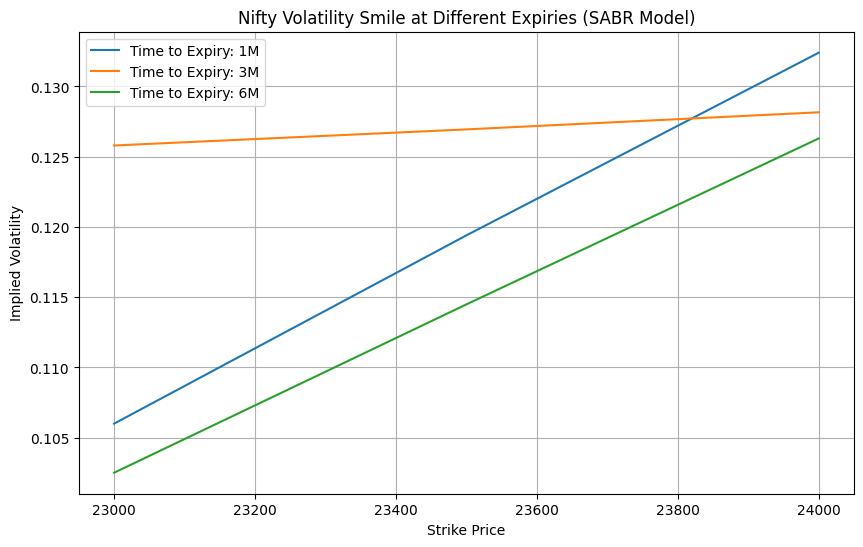

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the computed IV data
file_path = "/content/Nifty_Option_IV_Merged.csv"
df = pd.read_csv(file_path)

# Keep relevant columns
df = df[['Strike Price', 'Time to Expiry (T)', 'Spot Price', 'IV']].dropna()

# Get Unique Strikes & Expiries
strikes = sorted(df['Strike Price'].unique())
expiries = [1/12, 3/12, 6/12]  # 1M, 3M, 6M expiries

# **SABR Model Function**
def sabr_vol(alpha, beta, rho, nu, F, K, T):
    if K == F:
        return alpha / (F**(1-beta))
    logFK = np.log(K / F)
    z = (nu / alpha) * (F * K)**((1-beta)/2) * logFK
    chi_z = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
    return (alpha / (F * K)**((1-beta)/2)) * (1 + ((1-beta)**2 / 24) * logFK**2) * (z / chi_z)

# **SABR Parameter Calibration**
def calibrate_sabr(F, strikes, ivs, T):
    def error(params):
        alpha, beta, rho, nu = params
        errors = [(sabr_vol(alpha, beta, rho, nu, F, K, T) - ivs[i])**2 for i, K in enumerate(strikes)]
        return np.sum(errors)

    # Initial guesses for SABR parameters
    initial_params = [0.2, 0.5, -0.3, 0.4]
    bounds = [(0, 2), (0, 1), (-1, 1), (0, 2)]
    result = minimize(error, initial_params, bounds=bounds, method='L-BFGS-B')
    return result.x

# **Compute Future Volatilities**
vol_matrix = np.zeros((len(expiries), len(strikes)))
F = df['Spot Price'].iloc[0]  # Current Nifty Spot Price

for i, T in enumerate(expiries):
    df_expiry = df[df['Time to Expiry (T)'].between(T - 0.02, T + 0.02)]
    strikes_expiry = df_expiry['Strike Price'].values
    ivs_expiry = df_expiry['IV'].values

    if len(strikes_expiry) > 5:  # Ensure sufficient data for calibration
        alpha, beta, rho, nu = calibrate_sabr(F, strikes_expiry, ivs_expiry, T)
        for j, K in enumerate(strikes):
            vol_matrix[i, j] = sabr_vol(alpha, beta, rho, nu, F, K, T)

# **Plot Volatility Smile**
plt.figure(figsize=(10, 6))
for i, T in enumerate(expiries):
    plt.plot(strikes, vol_matrix[i], label=f'Time to Expiry: {int(T*12)}M')

plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Nifty Volatility Smile at Different Expiries (SABR Model)")
plt.legend()
plt.grid(True)
plt.show()
